# Spam classification using logistic regression

We have 4601 email addresses with 57 features. The data can be found on [GitHub](https://github.com/probml/pmtk3/tree/master/data/spamData). The column names can be found [here](ftp://ftp.ics.uci.edu/pub/machine-learning-databases/spambase/spambase.names). We want to predict whether the email is spam or not, so we have a binary response, where 1 indicates spam and 0 indicates non-spam.

You can find some utility functions on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap08/classifiers.py).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from classifiers import read_spam_data, transform_log, transform_binary
#from sklearn.linear_model import LogisticRegression # reference sklearn implementation
from classifiers import LogisticRegression

train_data, test_data = read_spam_data()
train_data.head()

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.21,0.28,0.5,0.0,0.14,0.28,0.21,0.07,0.00,...,0.0,0.0,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0
1,1,0.00,0.00,0.0,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.0,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0
2,1,0.00,0.00,0.0,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.0,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0
3,1,0.00,0.00,0.0,0.0,1.85,0.00,0.00,1.85,0.00,...,0.0,0.0,0.223,0.0,0.000,0.000,0.000,3.000,15.0,54.0
4,1,0.00,0.00,0.0,0.0,1.92,0.00,0.00,0.00,0.00,...,0.0,0.0,0.054,0.0,0.164,0.054,0.000,1.671,4.0,112.0


In logistic regression, we let 

\begin{equation}
y \mid \mathbf{x} \sim \operatorname{Bernoulli}\left(\frac{1}{1 + \exp\left(-\left(w_0 + \mathbf{w}^\intercal \mathbf{x}\right)\right)}\right),
\end{equation}

so if we make $N$ observations the likelihood is

\begin{equation}
L\left(w_0, \mathbf{w}\right) = \prod_{i=1}^N\left(\frac{1}{1 + \exp\left(-\left(w_0 + \mathbf{w}^\intercal \mathbf{x}\right)\right)}\right)^{y_i}\left(\frac{1}{1 + \exp\left(w_0 + \mathbf{w}^\intercal \mathbf{x}\right)}\right)^{1-y_i}.
\end{equation}

Define $\tilde{y}_i = 2y_i - 1.$ We want to minimize the negative log-likelihood, which is

\begin{equation}
J\left(w_0, \mathbf{w}\right) = \sum_{i=1}^N\log\left(1 + \exp\left(-\tilde{y}_i\left(w_0 + \mathbf{w}^\intercal \mathbf{x}\right)\right)\right).
\end{equation}

In practice, this function is not always convex, so we add some regularization. Now, we minimize

\begin{equation}
J_\lambda\left(w_0, \mathbf{w}\right) = \sum_{i=1}^N\log\left(1 + \exp\left(-\tilde{y}_i\left(w_0 + \mathbf{w}^\intercal \mathbf{x}\right)\right)\right) + \frac{\lambda}{2}\mathbf{w}^\intercal\mathbf{w}.
\end{equation}

Note that there is no penalty for $w_0$. One way to minimize this is with Newton's algorithm. To do so, we need to calculate the gradient $\mathbf{g}$ and Hessian $\mathbf{H}$. In exercise 3 (not shown), I show that

\begin{align}
\mathbf{g}\left(w_0, \mathbf{w}\right) &= \tilde{\mathbf{X}}^\intercal\left(\boldsymbol\mu - \mathbf{y}\right) + \lambda\begin{pmatrix}0 \\ \mathbf{w}\end{pmatrix} \\
\mathbf{H}\left(w_0, \mathbf{w}\right) &= \tilde{\mathbf{X}}^\intercal \mathbf{M} \tilde{\mathbf{X}} 
+ \lambda
\begin{pmatrix}
0 & \mathbf{0} \\
\mathbf{0} & I
\end{pmatrix},
\end{align}

where $\tilde{\mathbf{X}}$ is the data matrix with a column of 1s inserted as the first column. Also, we have defined

\begin{equation}
\boldsymbol\mu = \begin{pmatrix}
\left(1 + \exp\left(-\left(w_0 + \mathbf{w}^\intercal\mathbf{x}_1\right)\right)\right)^{-1}\\
\left(1 + \exp\left(-\left(w_0 + \mathbf{w}^\intercal\mathbf{x}_2\right)\right)\right)^{-1}\\
\vdots \\
\left(1 + \exp\left(-\left(w_0 + \mathbf{w}^\intercal\mathbf{x}_N\right)\right)\right)^{-1}\\
\end{pmatrix},
~\text{and}~
\mathbf{M} = \operatorname{diag}\left(
\mu_1(1-\mu_1), \mu_2(1-\mu_2), \ldots,\mu_N(1-\mu_N)
\right).
\end{equation}

Let $\boldsymbol\theta = (w_0,\mathbf{w})^\intercal$. Choose some initial estimate for $\boldsymbol\theta_0$. Then, by Newton's method,

\begin{equation}
\mathbf{H}\left(\boldsymbol\theta_k\right)\left(\boldsymbol\theta_{k+1} - \boldsymbol\theta_{k}\right) = -\mathbf{g}\left(\boldsymbol\theta_k\right).
\end{equation}

In [2]:
#logReg = LogisticRegression(solver='newton-cg', C=1) # sklearn implementation, only newton-cg converges
logReg = LogisticRegression(regularization = 1)
logReg.fit(train_data.drop('spam', axis = 1).as_matrix(), train_data['spam'].as_matrix())
print(logReg.intercept_)
print(logReg.coef_)
print(1-logReg.score(train_data.drop('spam', axis = 1).as_matrix(), train_data['spam'].as_matrix()))
print(1-logReg.score(test_data.drop('spam', axis = 1).as_matrix(), test_data['spam'].as_matrix()))

-1.49981367068
[ -1.26600248e-01  -1.56094390e-01   2.54708222e-01   8.58581226e-01
   4.09630906e-01   8.96135831e-01   2.19302802e+00   7.60903407e-01
   6.71931927e-01   1.01103996e-01  -2.82796444e-01  -1.83924290e-01
  -1.11320045e-01   1.03485121e-01   5.54364725e-01   1.18430618e+00
   1.06659155e+00   1.31293171e-01   1.43401894e-01   7.11353892e-01
   2.31623776e-01   3.36640589e-01   1.87194517e+00   6.08773300e-01
  -1.82320650e+00  -5.14474564e-01  -4.14759176e+00  -1.98631296e-01
  -1.18020809e+00  -1.99879005e-01  -1.77496082e-01   1.48991710e-02
  -7.45306456e-01  -1.68448134e-01  -5.55552499e-01   8.47931331e-01
   3.72525690e-02  -6.12885760e-01  -1.00486600e+00  -1.36561188e-01
  -1.16561300e+00  -1.59350006e+00  -9.86968673e-01  -1.38680860e+00
  -7.55505052e-01  -1.82108130e+00  -6.55434252e-01  -1.61610798e+00
  -1.18107595e+00  -3.44812567e-01  -3.76344925e-01   2.25717319e-01
   4.05625095e+00   1.06168683e+00  -1.38267945e-02   8.02586523e-03
   4.62754722e-04]


The default settings work pretty well and give us a 7% misclassification rate. Let us try various transformations.

- Standardize, that is, $\displaystyle\frac{\mathbf{x}_j - \hat{\mu}_j}{\hat{\sigma}_j}$
- log, $\log\left(\mathbf{x}_j + 0.1\right)$
- Binarize, $\mathbb{I}\left(\mathbf{x}_j > 0\right)$

You can see the transformations and the logistic regression class that I wrote by hand on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap08/classifiers.py).

In [3]:
from sklearn import preprocessing

# transform the data
ytrain = train_data['spam'].as_matrix()
ytest = test_data['spam'].as_matrix()
Xtrain_raw = train_data.drop('spam', axis = 1).as_matrix()
Xtest_raw = test_data.drop('spam', axis = 1).as_matrix()
Xtrain_standard = preprocessing.scale(Xtrain_raw, axis=0)
Xtest_standard = preprocessing.scale(Xtest_raw, axis=0)
Xtrain_log = np.apply_along_axis(transform_log, axis = 0, arr=Xtrain_raw)
Xtest_log = np.apply_along_axis(transform_log, axis = 0, arr=Xtest_raw)
Xtrain_binary = np.apply_along_axis(transform_binary, axis = 0, arr=Xtrain_raw)
Xtest_binary = np.apply_along_axis(transform_binary, axis = 0, arr=Xtest_raw)

data_transform = ['Raw', 'Standard', 'Log', 'Binary']
Xtrain = [Xtrain_raw, Xtrain_standard, Xtrain_log, Xtrain_binary]
Xtest = [Xtest_raw, Xtest_standard, Xtest_log, Xtest_binary]

## now run lots of models to find regularization parameter
regularization = np.linspace(0, 20, num=41)
misclassification_rates = pd.DataFrame(dtype=np.float64,
                                       index = np.arange(len(regularization)),
                                       columns = ['Regularization'] + 
                                       list(map(lambda x : x + ' Train',  data_transform)) + 
                                       list(map(lambda x : x + ' Test',  data_transform)))
for i in range(len(regularization)):
    misclassification_rates.iloc[i]['Regularization'] = regularization[i]
    if regularization[i] == 0:
        regularization[i] += 0.01 # hack when there's no convergence.
    logReg = LogisticRegression(regularization = regularization[i])
    for j in range(len(data_transform)):
        logReg.fit(Xtrain[j], ytrain)
        misclassification_rates.iloc[i][data_transform[j] + ' Train'] = 1 - logReg.score(Xtrain[j], ytrain)
        misclassification_rates.iloc[i][data_transform[j] + ' Test'] = 1 - logReg.score(Xtest[j], ytest)
misclassification_rates

,Regularization,Raw Train,Standard Train,Log Train,Binary Train,Raw Test,Standard Test,Log Test,Binary Test
0,0.0,0.070799,0.070147,0.051876,0.064600,0.076172,0.086589,0.058594,0.074219
1,0.5,0.069494,0.072431,0.051223,0.064274,0.070964,0.087891,0.059245,0.072266
2,1.0,0.069821,0.074062,0.050571,0.063295,0.070312,0.087240,0.059896,0.072266
3,1.5,0.071126,0.075367,0.049918,0.063295,0.070312,0.085938,0.060547,0.072917
4,2.0,0.072757,0.076020,0.050245,0.063295,0.069661,0.084635,0.061198,0.073568
5,2.5,0.073409,0.075367,0.050571,0.063295,0.071615,0.085286,0.059896,0.074219
6,3.0,0.072757,0.075693,0.051876,0.063948,0.072266,0.084635,0.059896,0.074219
7,3.5,0.074715,0.075367,0.051223,0.063295,0.075521,0.085286,0.059896,0.074219
8,4.0,0.075693,0.076020,0.051223,0.063622,0.075521,0.083984,0.059896,0.074219
9,4.5,0.076020,0.076020,0.051223,0.063295,0.076823,0.084635,0.059896,0.074219


Let's plot these results.

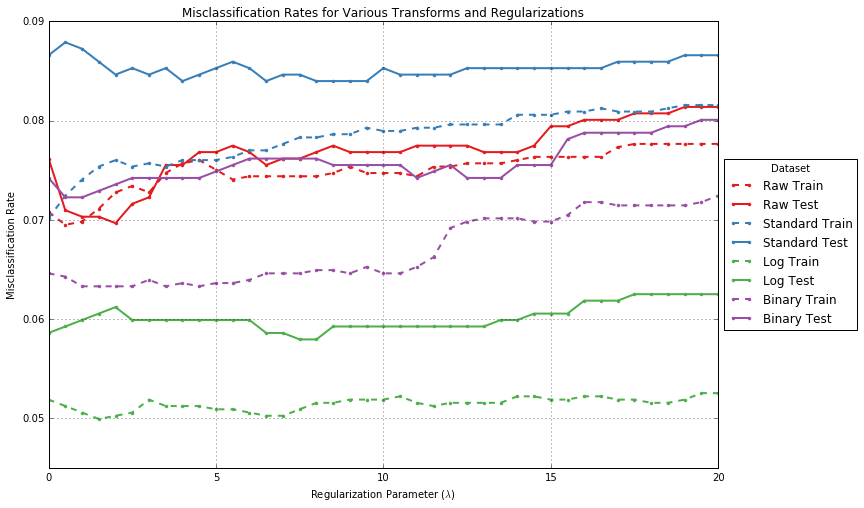

In [4]:
import matplotlib.pyplot as plt
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
plt.figure(figsize=(12,8))
for i in range(len(data_transform)):
    plt.plot(misclassification_rates['Regularization'], misclassification_rates[data_transform[i] + ' Train'],
             color=colors[i], linestyle='--', linewidth=2, marker='.')
    plt.plot(misclassification_rates['Regularization'], misclassification_rates[data_transform[i] + ' Test'],
             color=colors[i], linestyle='-', linewidth=2, marker='.')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), title="Dataset")
plt.ylabel("Misclassification Rate")
plt.xlabel("Regularization Parameter ($\lambda$)")
plt.title("Misclassification Rates for Various Transforms and Regularizations")
plt.show()

The problem tells us to select the regularization paramter with cross validation, but that seems pointless. We see that the log transform performs best with a misclassification rate of 5.8% when $\lambda = 8$.